In [22]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

# импортируем функцию, описывающую тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

### Подготовка датасета

In [23]:
dirname = os.path.abspath(os.curdir) + r'\data'
lake_ds = pd.read_csv(path.join(os.sep, dirname, 'dataset.csv')) # Читаем .csv файл, в которо содержаьтся данные с годовым количеством осадков в озере Верхнее с 1900 по 1986 год
lake_ds.set_index('Year').sort_index()

,x
Year,
1,28.55
2,27.37
3,25.60
4,29.93
5,27.61
...,...
83,35.82
84,32.27
85,29.09


In [24]:
ds = lake_ds['Year'] + 1899 # Добавим год, чтобы отображать данны
lake_ds['Year'] = ds

In [25]:
df = lake_ds
df.describe()

,Year,x
count,87.000000,87.000000
mean,1943.000000,30.000115
std,25.258662,3.457538
min,1900.000000,22.790000
25%,1921.500000,27.590000
50%,1943.000000,29.730000
75%,1964.500000,32.310000
max,1986.000000,39.930000


### Отрисовываем временной ряд

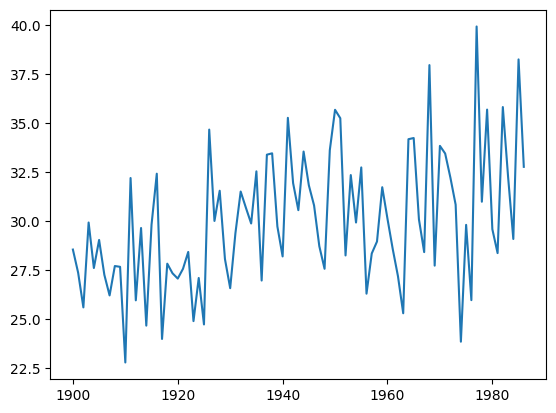

In [26]:
plt.plot(df['Year'], df['x'])

### Проверка ряда на стационарность

In [27]:
def test_adfuller(ts, name):
    alpha = 0.05

    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [28]:
test_adfuller(ts=df['x'], name='Осадки')

Тест Дики-Фуллера ряда Осадки :
Test Statistic                -8.279505e+00
p-value                        4.559966e-13
#Lags Used                     0.000000e+00
Number of Observations Used    8.600000e+01
Critical Value (1%)           -3.508783e+00
Critical Value (5%)           -2.895784e+00
Critical Value (10%)          -2.585038e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


### Удаление тренда и сезонности

In [29]:
# Возвращаем временной ряд без тренда
def get_nottrend(ts):
    nottrend = []
    for i in range(1, len(ts)):
        nottrend.append(ts[i]-ts[i-1])
    return nottrend

# Возвращаем временной ряд без сезонности
def get_notseason(ts, s):
    notseason = []
    for i in range(s, len(ts)):
        notseason.append(ts[i]-ts[i-s])
    return notseason

In [30]:
s = 6
ts = df["x"].to_numpy()
nottrend = get_nottrend(ts)
notseason = get_notseason(ts,s)

#### Работаем с рядом без тренда

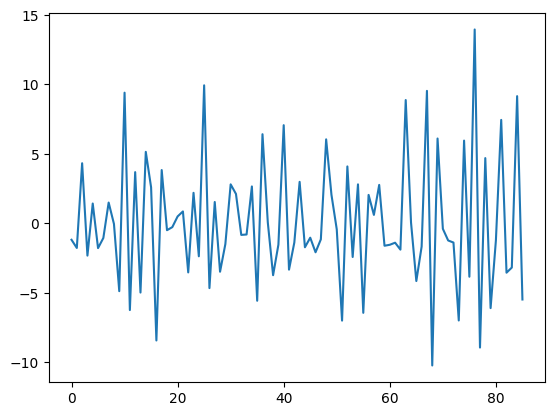

In [31]:
# отрисовываем временной ряд без тренда
plt.plot(nottrend)

In [32]:
test_adfuller(nottrend, 'Осадки')

Тест Дики-Фуллера ряда Осадки :
Test Statistic                -6.569672e+00
p-value                        7.994495e-09
#Lags Used                     5.000000e+00
Number of Observations Used    8.000000e+01
Critical Value (1%)           -3.514869e+00
Critical Value (5%)           -2.898409e+00
Critical Value (10%)          -2.586439e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


#### Работаем с рядом без сезонности

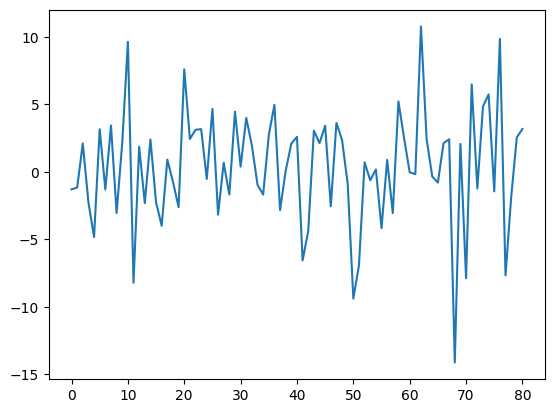

In [33]:
# отрисовываем временной ряд без сезонности
plt.plot(notseason)

In [34]:
# Проведем тест Дики-Фуллера на временном ряде без сезонности
test_adfuller(notseason, 'Осадки')

Тест Дики-Фуллера ряда Осадки :
Test Statistic                 -2.628966
p-value                         0.087157
#Lags Used                     12.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


#### Автокорреляция

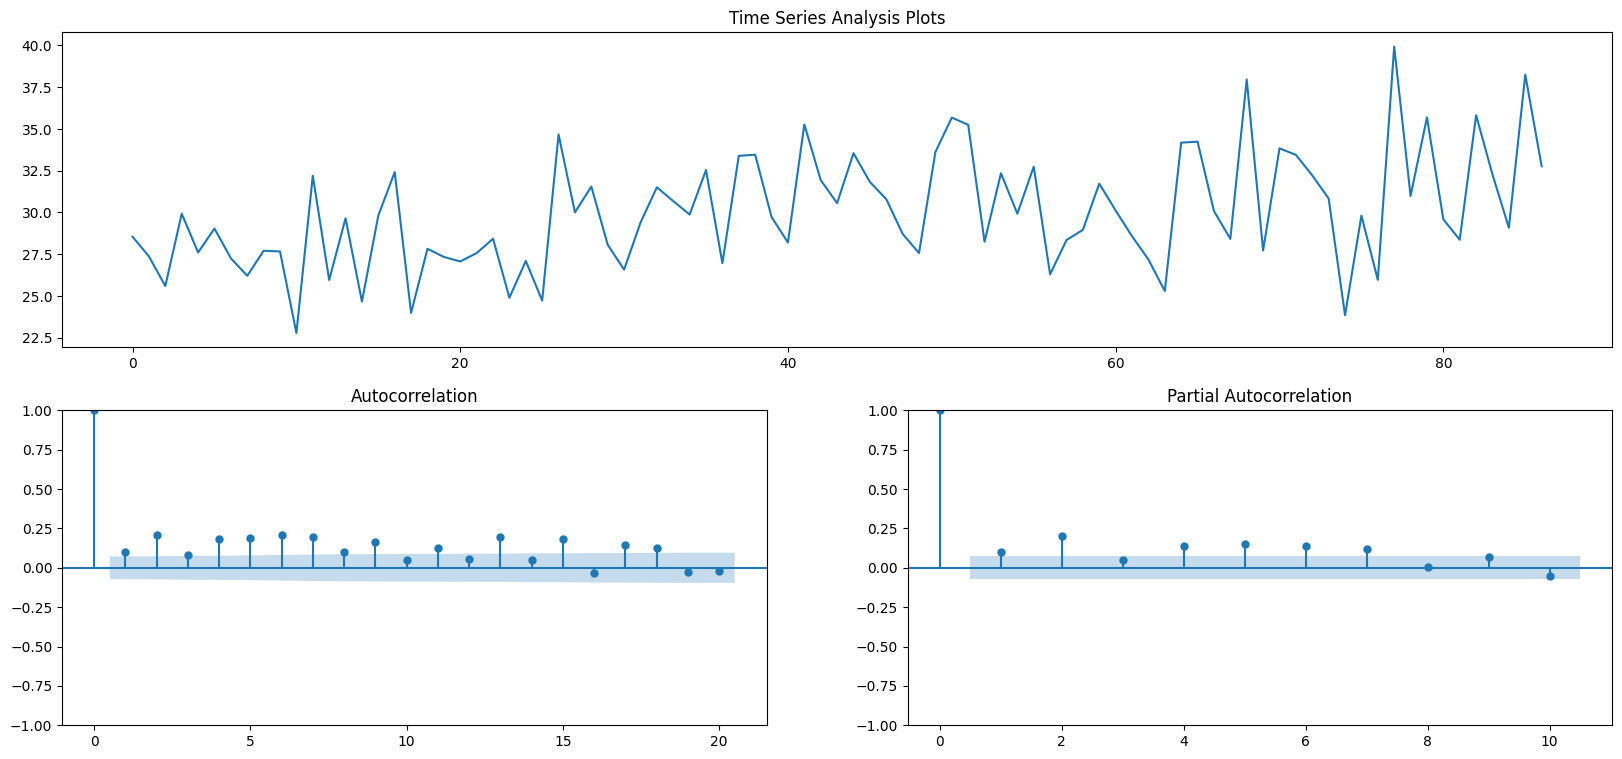

In [35]:
ts = df['x']

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

### AR модель

In [135]:
dirname = os.path.abspath(os.curdir) + r'\data'
df = pd.read_csv(path.join(os.sep, dirname, 'dataset.csv'), names=['n', 'x'], skiprows=1) # Читаем .csv файл, в которо содержаьтся данные с годовым количеством осадков в озере Верхнее с 1900 по 1986 год
df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

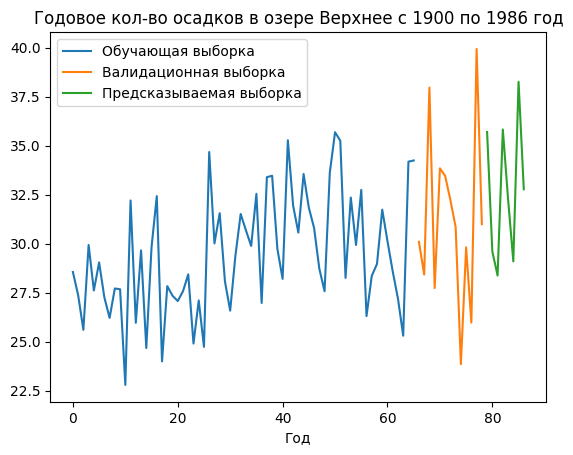

In [136]:
plt.plot(train_df.t, train_df.x, label='Обучающая выборка')
plt.plot(validate_df.t, validate_df.x, label='Валидационная выборка')
plt.plot(forecast_df.t, forecast_df.x, label='Предсказываемая выборка')

plt.legend()
plt.title('Годовое кол-во осадков в озере Верхнее с 1900 по 1986 год')
plt.xlabel('Год')
plt.show()

In [133]:
mod = AutoReg(df.t, 3, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                   87
Model:                     AutoReg(3)   Log Likelihood                2454.095
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 07 Feb 2024   AIC                          -4898.189
Time:                        09:40:44   BIC                          -4886.035
Sample:                             3   HQIC                         -4893.303
                                   87                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667    3.6e-15   1.85e+14      0.000       0.667       0.667
t.L1           1.0000   3.53e-15   2.83e+14      0.000       1.000       1.000
t.L2           0.3333   7.35e-17   4.53e+15      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                   87
Model:                     AutoReg(3)   Log Likelihood                2454.095
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 07 Feb 2024   AIC                          -4898.189
Time:                        09:40:37   BIC                          -4886.035
Sample:                             3   HQIC                         -4893.303
                                   87                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   2.49e-15   2.68e+14      0.000       0.667       0.667
t.L1           1.0000   2.41e-15   4.15e+14      0.000       1.000       1.000
t.L2           0.3333   8.91e-17   3.74e+15      0.0

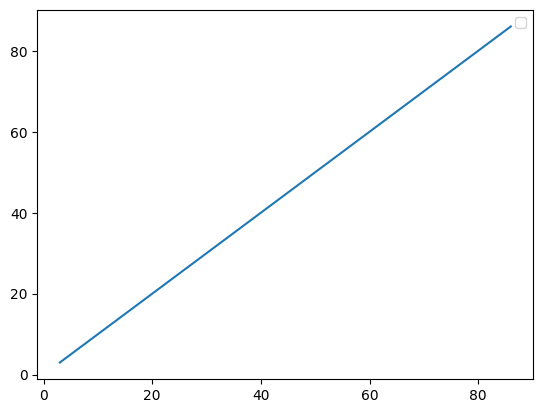

In [132]:
res = mod.fit(cov_type="HC0")
# смотрим, что изменилось
print(res.summary())
fig = res.plot_predict(0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   87
Model:                     AutoReg(0)   Log Likelihood                -230.873
Method:               Conditional MLE   S.D. of innovations              3.438
Date:                Wed, 07 Feb 2024   AIC                            465.746
Time:                        09:43:08   BIC                            470.678
Sample:                             0   HQIC                           467.732
                                   87                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0001      0.369     81.400      0.000      29.278      30.722


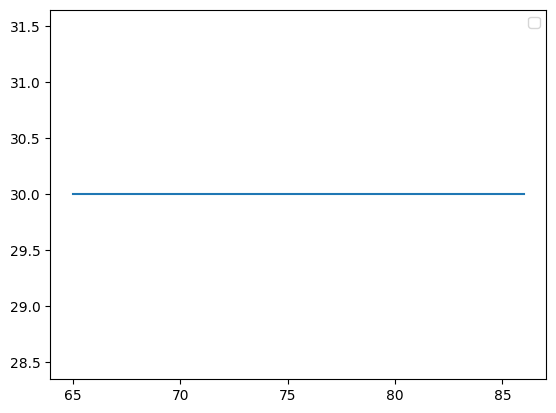

In [137]:
sel = ar_select_order(df.x, 24, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())
fig = res.plot_predict(train_cutoff)

In [123]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(forecast_df['y'][len(df['y'])-1]), dynamic=False)

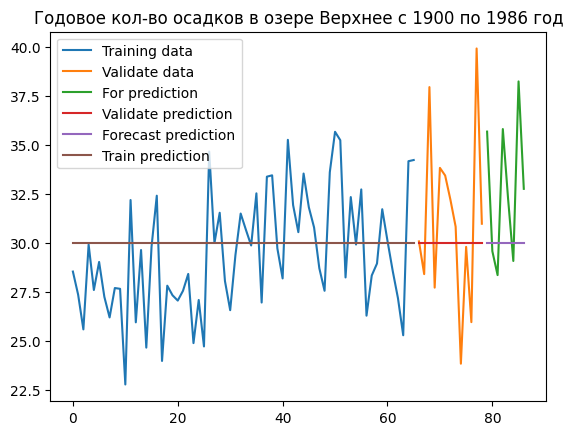

In [118]:
plt.plot(train_df['y'], train_df['x'], label='Training data')
plt.plot(validate_df['y'], validate_df['x'], label='Validate data')
plt.plot(forecast_df['y'], forecast_df['x'], label='For prediction')
plt.plot(validate_df['y'], v_pred, label='Validate prediction ')
plt.plot(forecast_df['y'], f_pred, label='Forecast prediction')
plt.plot(train_df['y'], pred, label='Train prediction')

plt.legend()
plt.title('Годовое кол-во осадков в озере Верхнее с 1900 по 1986 год')
plt.show()